In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.catalog import get_expo_map, lnls_xy
from tqdm import tqdm
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import seaborn as sns
from astropy.table import Table 
import astropy.io.fits as fits
%matplotlib inline

# Catalogs construction

In [3]:
cols_to_retain_photometry = [
'flux_g',
'flux_r',
'flux_z',
'flux_w1',
'flux_w2',
'flux_w3',
'flux_w4',
'mag_g',
'mag_r',
'mag_z',
'mag_w1',
'mag_w2',
'mag_w3',
'mag_w4',
]

cols_to_retain_positional = [
'is_counterpart',
'name_csc',	
'ra_csc',	
'dec_csc', 
'r_98_csc',	
'sep_csc_desi',	
'flux_csc_05_2', 
'desi_id',	
'ra_desi',	
'dec_desi', 
'radec_err_desi' ]

cols_to_retain = cols_to_retain_photometry + cols_to_retain_positional


x_ray_flux_lim = 1e-14#3e-15
col_to_ctps_filter = 'isin_r_false_03'

## Counterparts catalog

In [4]:
ctps = pd.read_pickle(data_path+'/multi-wave/cparts_rf135.pkl')
ctps['is_counterpart'] = True


ctps = ctps[ctps['flux_csc_05_2']>x_ray_flux_lim]
ctps_secure = ctps[ctps[col_to_ctps_filter]==True]
ctps_secure = ctps_secure[cols_to_retain]
ctps_secure.head(3)

,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,is_counterpart,name_csc,ra_csc,dec_csc,r_98_csc,sep_csc_desi,flux_csc_05_2,desi_id,ra_desi,dec_desi,radec_err_desi
35,3.412663,0.622760,3.026884,-10.295788,NaN,NaN,NaN,21.167267,23.014198,21.297510,NaN,NaN,17.664206,NaN,True,2CXO J023537.5-004326,38.906404,-0.724028,11.046618,0.280365,2.653797e-14,326203_2801,38.906413,-0.723951,0.370844
43,1.342113,0.360270,-0.139039,-7.543176,NaN,NaN,NaN,22.180527,23.608431,NaN,NaN,NaN,NaN,NaN,True,2CXO J090108.3+322208,135.284923,32.369098,1.711105,0.171539,1.550007e-13,507272_2732,135.284962,32.369133,0.041128
68,5.510463,6.973393,6.785502,18.494034,NaN,NaN,NaN,20.647030,20.391390,20.421045,19.33242,18.812794,18.189835,16.394829,True,2CXO J095839.2+020506,149.663599,2.085178,1.169706,0.095643,1.068019e-14,342486_3719,149.663594,2.085204,0.062084


In [5]:
#q = pd.read_pickle(data_path+'/multi-wave/cparts_rf135.pkl')
#q

## Field sources catalog

In [6]:
field_srcs = pd.read_pickle(data_path+'/multi-wave/field_random_rf135.pkl')
field_srcs['is_counterpart'] = False
field_srcs['flux_csc_05_2'] = np.nan
field_srcs = field_srcs[cols_to_retain]
field_srcs.head(3)

,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,is_counterpart,name_csc,ra_csc,dec_csc,r_98_csc,sep_csc_desi,flux_csc_05_2,desi_id,ra_desi,dec_desi,radec_err_desi
0,0.176715,0.267206,0.656951,5.071526,6.481035,-106.662216,2176.851562,24.381815,23.932882,22.956167,20.737154,20.470890,NaN,14.155428,False,2CXO J000001.7+003824,0.007351,0.640170,1.598058,20.221833,NaN,334688_502,0.012118,0.637199,0.057642
1,0.276117,0.328782,0.393997,1.041408,-0.802119,-9.975758,709.778076,23.897264,23.707729,23.511269,22.455948,NaN,NaN,15.372193,False,2CXO J000001.7-500850,0.007301,-50.147369,1.198873,28.624252,NaN,76434_405,0.019367,-50.149223,0.058166
2,0.233718,0.334758,0.306467,2.950701,8.461881,-187.205292,6643.588867,24.078270,23.688173,23.784042,21.325188,20.181334,NaN,12.943994,False,2CXO J000002.0-500535,0.008631,-50.093100,1.312859,19.651107,NaN,77358_13,0.000415,-50.094518,0.065944


## Joined catalog + color features

In [7]:
photo_cat = pd.concat([ctps_secure, field_srcs])
photo_cat.reset_index(inplace=True)

features_cols = ['mag_g','mag_r','mag_z'] 

features_cols += ['mag_w1', 'mag_w2']#, 'mag_w3', 'mag_w4']

features_cols += ['col_gr', 'col_rz']#, 'col_gz']
features_cols += ['col_zw1', 'col_rw2']

target_col = ['is_counterpart']


photo_cat['col_gr'] = photo_cat['mag_g'] - photo_cat['mag_r']
photo_cat['col_rz'] = photo_cat['mag_r'] - photo_cat['mag_z']
#photo_cat['col_gz'] = photo_cat['mag_g'] - photo_cat['mag_z']
photo_cat['col_zw1'] = photo_cat['mag_z'] - photo_cat['mag_w1']
photo_cat['col_rw2'] = photo_cat['mag_r'] - photo_cat['mag_w2']

photo_cat = photo_cat[features_cols+target_col]

photo_cat = photo_cat.replace([np.inf, -np.inf], np.nan)



In [8]:
features_cols+target_col

['mag_g',
 'mag_r',
 'mag_z',
 'mag_w1',
 'mag_w2',
 'col_gr',
 'col_rz',
 'col_zw1',
 'col_rw2',
 'is_counterpart']

# Data preprocessing

In [9]:
photo_cat.dropna(inplace=True, subset = features_cols)
from sklearn.model_selection import train_test_split

_, photo_cat_plot = train_test_split(photo_cat, test_size=0.3, stratify = photo_cat[target_col])



In [10]:
photo_cat.head(5)

,mag_g,mag_r,mag_z,mag_w1,mag_w2,col_gr,col_rz,col_zw1,col_rw2,is_counterpart
2,20.647030,20.391390,20.421045,19.332420,18.812794,0.255640,-0.029655,1.088625,1.578596,True
3,12.751101,12.498560,12.179626,12.732568,13.387960,0.252542,0.318933,-0.552941,-0.889400,True
4,23.021368,22.932072,21.738939,19.783581,19.917938,0.089296,1.193132,1.955359,3.014133,True
5,23.782465,23.168701,22.721001,20.551594,20.038231,0.613764,0.447701,2.169407,3.130470,True
6,24.307516,23.362076,22.509741,20.678108,21.148252,0.945440,0.852335,1.831633,2.213823,True


In [11]:
print(photo_cat.is_counterpart.value_counts())
print(photo_cat_plot.is_counterpart.value_counts())

False    40929
True     12057
Name: is_counterpart, dtype: int64
False    12279
True      3617
Name: is_counterpart, dtype: int64


## feature scaling

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

photo_cat_scaled = photo_cat_plot.copy()
scaler = StandardScaler()
scaler.fit(photo_cat_scaled[features_cols])
photo_cat_scaled[features_cols] = scaler.transform(photo_cat_scaled[features_cols])
#photo_cat_scaled.describe()

X_train, X_test, y_train, y_test = train_test_split(photo_cat_scaled[features_cols], photo_cat_scaled[target_col[0]], test_size=0.3, stratify = photo_cat_scaled[target_col[0]])


In [15]:
def assess_classifier(clf):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


    plt.figure(figsize=(10,5))
    ax = sns.kdeplot(x = clf.predict_proba(X_test)[:,1], hue = y_test.values)
    ax.set(title = 'test sample, '+str(clf), ylabel  = 'probability density', xlabel = 'classifier predicted probability')
    plt.legend(title='Counterpart', labels=['X-ray counterpart', 'Field source'])



    proba_axis = np.linspace(0,1,20)
    completeness = np.ones_like(proba_axis) #fraction of sources classifued as counterparts out of all counterparts
    purity = np.ones_like(proba_axis) #fraction of sources with a correct identification as a X-ray counterpart

    for i,prob_val in enumerate(proba_axis):
        if i//5 == 0:
            print('### purity/completeness ',i,'/', len(proba_axis))
        y_pred_tmp = clf.predict_proba(X_test)[:,1] > prob_val
        cm_tmp = confusion_matrix(y_test, y_pred_tmp)
        completeness[i] = cm_tmp[1,1]/(cm_tmp[1,1]+cm_tmp[1,0])
        purity[i] = cm_tmp[1,1]/(cm_tmp[0,1]+cm_tmp[1,1])

    plt.figure(figsize=(10,5))
    plt.plot(proba_axis, completeness, label = 'completeness = [true positives]/[true positives + false positives]')
    plt.plot(proba_axis, purity, label = 'purity = [true positives]/[true positives + false negatives]')
    plt.xlabel('classifier predicted probability')
    plt.ylabel('completeness/purity')
    plt.suptitle('test sample, '+str(clf))
    plt.legend()
        

# Classification models

## SVM

              precision    recall  f1-score   support

       False       0.88      0.88      0.88      3684
        True       0.84      0.84      0.84      2757

    accuracy                           0.86      6441
   macro avg       0.86      0.86      0.86      6441
weighted avg       0.86      0.86      0.86      6441

[[3234  450]
 [ 432 2325]]
### purity/completeness  0 / 20
### purity/completeness  1 / 20
### purity/completeness  2 / 20
### purity/completeness  3 / 20
### purity/completeness  4 / 20


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_84017/1161641824.py:25: RuntimeWarning: invalid value encountered in long_scalars
  purity[i] = cm_tmp[1,1]/(cm_tmp[0,1]+cm_tmp[1,1])


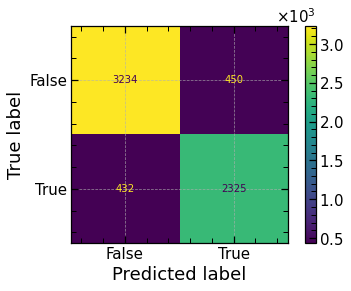

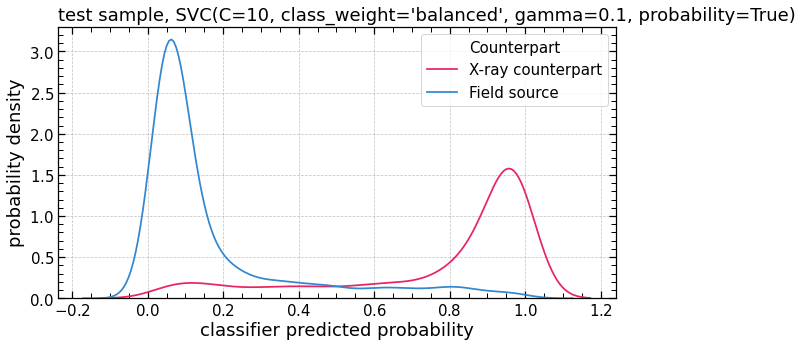

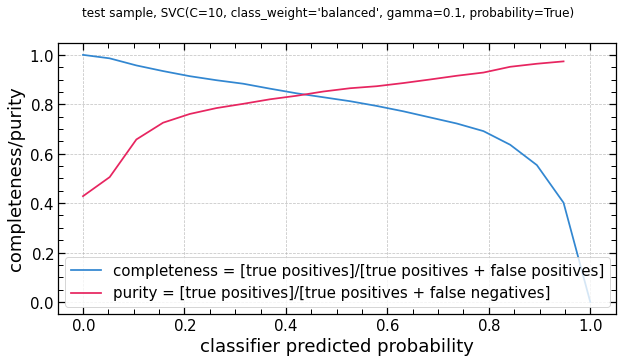

In [108]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf',  C = 10, gamma = 0.1,
            class_weight='balanced', probability = True)
svm.fit(X_train, y_train)

assess_classifier(svm)

## Logistic regression

              precision    recall  f1-score   support

       False       0.87      0.81      0.84      3684
        True       0.76      0.84      0.80      2757

    accuracy                           0.82      6441
   macro avg       0.82      0.82      0.82      6441
weighted avg       0.82      0.82      0.82      6441

[[2968  716]
 [ 443 2314]]
### purity/completeness  0 / 20
### purity/completeness  1 / 20
### purity/completeness  2 / 20
### purity/completeness  3 / 20
### purity/completeness  4 / 20


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_84017/1161641824.py:25: RuntimeWarning: invalid value encountered in long_scalars
  purity[i] = cm_tmp[1,1]/(cm_tmp[0,1]+cm_tmp[1,1])


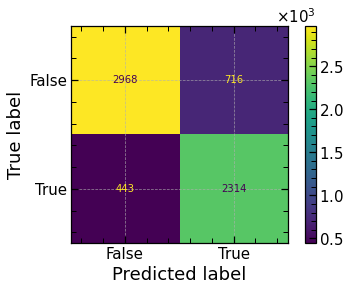

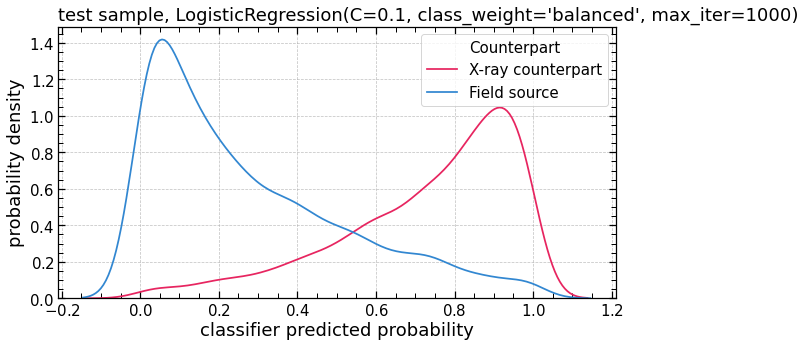

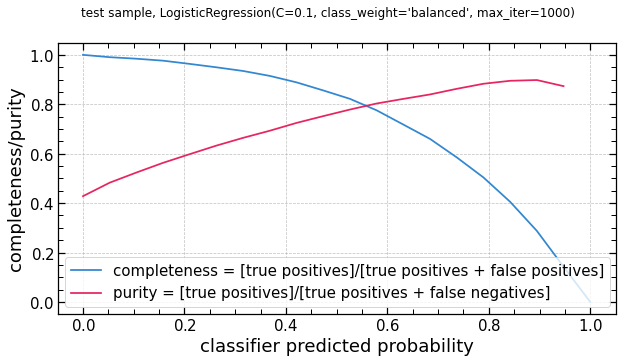

In [109]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', C = 0.1)
logreg.fit(X_train, y_train)

assess_classifier(logreg)

## Neural network

              precision    recall  f1-score   support

       False       0.96      0.97      0.97      3684
        True       0.91      0.86      0.88      1085

    accuracy                           0.95      4769
   macro avg       0.93      0.92      0.93      4769
weighted avg       0.95      0.95      0.95      4769

[[3588   96]
 [ 150  935]]
### purity/completeness  0 / 20
### purity/completeness  1 / 20
### purity/completeness  2 / 20
### purity/completeness  3 / 20
### purity/completeness  4 / 20


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_45336/1161641824.py:25: RuntimeWarning: invalid value encountered in long_scalars
  purity[i] = cm_tmp[1,1]/(cm_tmp[0,1]+cm_tmp[1,1])


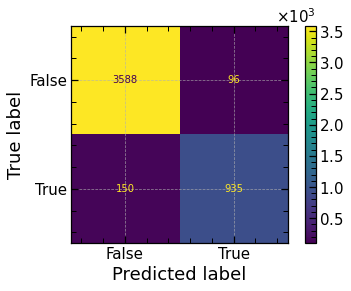

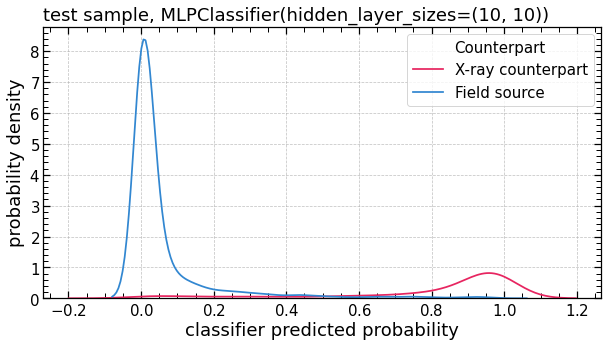

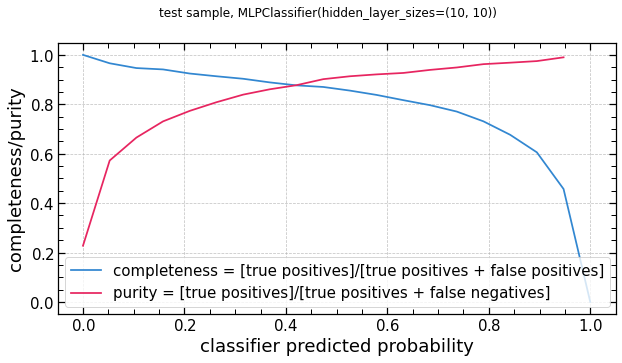

In [16]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes=(10, 10), activation='relu', )
nn.fit(X_train, y_train)

assess_classifier(nn)


## Random forest

              precision    recall  f1-score   support

       False       0.88      0.85      0.87      3684
        True       0.81      0.85      0.83      2757

    accuracy                           0.85      6441
   macro avg       0.85      0.85      0.85      6441
weighted avg       0.85      0.85      0.85      6441

[[3129  555]
 [ 410 2347]]
### purity/completeness  0 / 20
### purity/completeness  1 / 20
### purity/completeness  2 / 20
### purity/completeness  3 / 20
### purity/completeness  4 / 20


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_84017/1161641824.py:25: RuntimeWarning: invalid value encountered in long_scalars
  purity[i] = cm_tmp[1,1]/(cm_tmp[0,1]+cm_tmp[1,1])


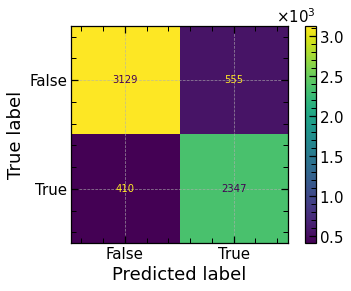

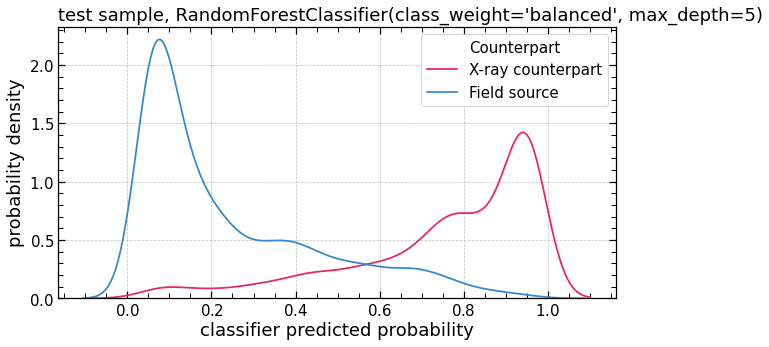

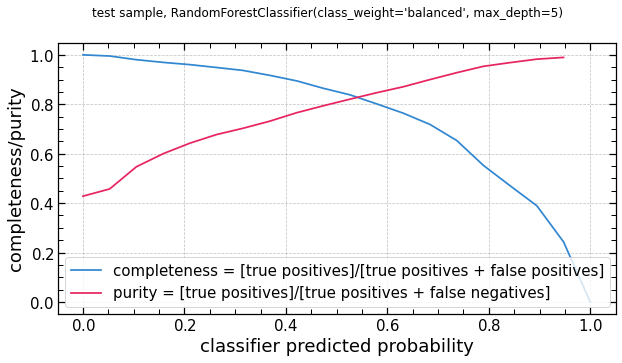

In [111]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)

assess_classifier(rf)